In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from mma import *
import gudhi as gd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from multipers import *
from joblib import Parallel, delayed
from multiprocessing import Pool, Manager, cpu_count
from sklearn.neighbors import KernelDensity
from joblib import parallel_backend
from numpy.polynomial.polynomial import polyfit
from benchmark_functions import *
from pandas import read_csv
from gudhi.point_cloud.timedelay import TimeDelayEmbedding
import seaborn as sns

## Retrieves the datasets from UCR

In [3]:
def get_dataset(dataset = "Coffee"):
    dataset_path = "./UCR/" + dataset + "/" + dataset + "_TRAIN.tsv"
    data = np.array(read_csv(dataset_path, delimiter='\t', header=None, index_col=0))
    return data
data = get_dataset()

In [4]:
tde = TimeDelayEmbedding().transform(data)
len(tde)

28

## A first example : Coffee. Time vs number of simplices

### Parameters

In [5]:
# benchmarks the time to compute coffee series
ntries = 1 # Numbers of tries of each series (to make a std, but that's with a parallel computing)
num = 10 # Numbers of lines in set_of_nlines
nlines = 300 # Number of lines at each tries
max_edge_length = 0.1 # Rips threshold
gaussian_var=0.3      # kde bandwidth
set_of_nlines = np.linspace(start=10, stop=300, num = num).astype(int) # set of number of lines

### Benchmark computation

In [6]:
times = np.empty(len(tde))
std = np.empty((len(tde), len(set_of_nlines)))
num_simplices = np.empty(len(tde))
for i in tqdm(range(len(tde))):
    times[i], _, num_simplices[i] = density_persistence_benchmark(
        tde[i],nlines, ntries = ntries, gaussian_var=gaussian_var, max_edge_length=max_edge_length,
        filtration="rips", max_dimension=2)

100%|███████████████████████████████████████████| 28/28 [01:04<00:00,  2.31s/it]


### Plot of this benchmark

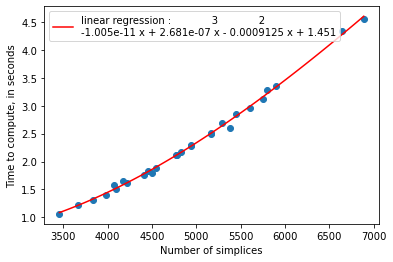

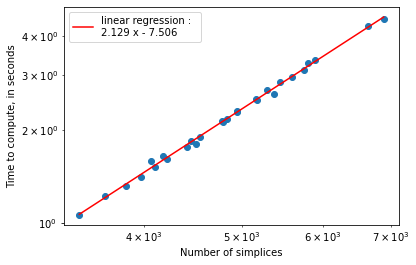

In [7]:
coeffs = np.polyfit(num_simplices, times,3) # Polyfit of degree 1
poly = np.poly1d(coeffs)
yfit = lambda x: poly(x)

plt.scatter(num_simplices, times)
linspace_ =np.linspace(start=min(num_simplices), stop = max(num_simplices), num=100) 
plt.plot(linspace_, yfit(linspace_), c='r', label = "linear regression : {}".format(poly))
plt.legend()
plt.savefig("UCR_Coffee_nlines_" +str(nlines)+".svg")
plt.xlabel("Number of simplices")
plt.ylabel("Time to compute, in seconds")
plt.show()

poly_log = np.poly1d(np.polyfit(np.log10(num_simplices), np.log10(times),1))
yfit_log = lambda x: np.power(10,poly_log(np.log10(x)))

plt.scatter(num_simplices, times)
linspace_ =np.linspace(start=min(num_simplices), stop = max(num_simplices), num=100) 
plt.loglog(linspace_, yfit_log(linspace_), c='r', label = "linear regression : {}".format(poly_log))
plt.legend()
plt.savefig("UCR_Coffee_nlines_loglog_" +str(nlines)+".svg")
plt.xlabel("Number of simplices")
plt.ylabel("Time to compute, in seconds")
plt.show()

## Another example : Wine dataset. Time vs number of simplices

In [8]:
data = get_dataset("Wine")
tde = TimeDelayEmbedding().transform(data)
print(len(tde))
# benchmarks the time to compute Wine series
ntries = 1
num = 10
nlines = 300
max_edge_length = 0.1
gaussian_var=0.3
max_alpha_square=0.1

57


In [9]:
simplex_tree = gd.RipsComplex(points=tde[0],max_edge_length= max_edge_length).create_simplex_tree(max_dimension=2)
print(simplex_tree.num_simplices())
simplex_tree = gd.AlphaComplex(points=tde[0]).create_simplex_tree(max_alpha_square=max_alpha_square)
print(simplex_tree.num_simplices())

19857
3142


In [10]:
times = np.empty(len(tde))
num_simplices = np.empty(len(tde))
for i in tqdm(range(len(tde))):
    times[i], _, num_simplices[i] = density_persistence_benchmark(
        tde[i],nlines, ntries = ntries, gaussian_var=gaussian_var, max_edge_length=max_edge_length,
        filtration="alpha", max_dimension=2, max_alpha_square=max_alpha_square)

100%|███████████████████████████████████████████| 57/57 [00:46<00:00,  1.23it/s]


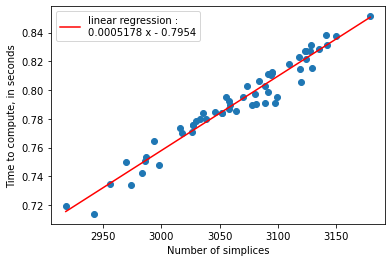

In [12]:
coeffs = np.polyfit(num_simplices, times,1)
poly = np.poly1d(coeffs)
yfit = lambda x: poly(x)
plt.scatter(num_simplices, times)
linspace_ =np.linspace(start=min(num_simplices), stop = max(num_simplices), num=100) 
plt.plot(linspace_, yfit(linspace_), c='r', label = "linear regression : {}".format(poly))
plt.legend()
plt.savefig("UCR_Wine_nlines_" +str(nlines)+".svg")
plt.xlabel("Number of simplices")
plt.ylabel("Time to compute, in seconds")
plt.show()